In [6]:
%load_ext autoreload
%autoreload 2
from covid_constants_and_util import *
import helper_methods_for_aggregate_data_analysis as helper
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import json
import datetime
import scipy
import time

JUST_TESTING = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
! pip install tornado

In [8]:
COLS_FROM_CORE_PLACES = ['safegraph_place_id', 'parent_safegraph_place_id', 'location_name', 'safegraph_brand_ids', 
                         'brands', 'top_category', 'sub_category', 'naics_code', 'latitude', 'longitude', 'street_address',
                         'city', 'region', 'postal_code', 'open_hours']
COLS_FROM_CORE_PLACES_FOOTPRINT = ['safegraph_place_id', 'polygon_class', 'area_square_feet']
COLS_FROM_WEEKLY_PATTERNS = ['safegraph_place_id', 'poi_cbg', 'visitor_home_cbgs', 'visitor_daytime_cbgs', 
                             'visitor_country_of_origin', 'distance_from_home', 'median_dwell', 'bucketed_dwell_times']

In [5]:
# The path is: /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/09/03/22
core_poi_df = helper.load_core_places_data(COLS_FROM_CORE_PLACES)

Loading /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/06/05/00/core_poi-part1.csv.gz


100%|##########| 1/1 [00:13<00:00, 13.77s/it]


Loading /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/06/05/00/core_poi-part2.csv.gz


100%|##########| 1/1 [00:14<00:00, 14.94s/it]


Loading /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/06/05/00/core_poi-part3.csv.gz


100%|##########| 1/1 [00:14<00:00, 14.15s/it]


Loading /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/06/05/00/core_poi-part4.csv.gz


100%|##########| 1/1 [00:13<00:00, 13.82s/it]


Loading /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/06/05/00/core_poi-part5.csv.gz


100%|##########| 1/1 [00:15<00:00, 15.59s/it]


Loading /media/gpu/easystore/Safegraph/Core Places US (Nov 2020 - Present)/core_poi/2021/06/05/00/core_poi-part6.csv.gz


100%|##########| 1/1 [00:15<00:00, 15.18s/it]


Loading core places info for 6462532 POIs


In [5]:
## Load the area column to the CORE_POIs.

footprint_df = helper.load_core_places_footprint_data(COLS_FROM_CORE_PLACES_FOOTPRINT)
ids_in_footprint_but_not_core = set(footprint_df.index) - set(core_poi_df.index)
print(f"footprint_df row count: {len(footprint_df)}, core_POI row count: {len(core_poi_df)}")
print("Warning: %i/%i (%.1f%%) POIs in footprint but not core data; dropping these" % 
      (len(ids_in_footprint_but_not_core), len(footprint_df), 100. * len(ids_in_footprint_but_not_core) / len(footprint_df)))
core_poi_df = pd.merge(core_poi_df, footprint_df, how='left', left_index=True, right_index=True, validate='one_to_one')
print("Missing data for footprint columns")
print(pd.isnull(core_poi_df[footprint_df.columns]).mean())

Loading /media/gpu/easystore/Safegraph/Geometry Footprint/August2020Release/SafeGraphPlacesGeoSupplementSquareFeet.csv.gz


100%|██████████| 1/1 [00:22<00:00, 22.04s/it]


Loaded core places footprint data for 5304326 POIs
footprint_df row count: 5304326, core_POI row count: 6462532
Missing data for footprint columns
polygon_class       0.210993
area_square_feet    0.210993
dtype: float64


In [6]:
print(f'Row count of core_poi_df: {len(core_poi_df)}')
core_poi_df.head(3)

Row count of core_poi_df: 6462532


,parent_safegraph_place_id,location_name,safegraph_brand_ids,brands,top_category,sub_category,naics_code,latitude,longitude,street_address,city,region,postal_code,open_hours,polygon_class,area_square_feet
safegraph_place_id,,,,,,,,,,,,,,,,
sg:0024c2de777b43abab827cb0898f3810,NaN,Copper Cup,NaN,NaN,Restaurants and Other Eating Places,Snack and Nonalcoholic Beverage Bars,722515.0,46.463144,-90.162791,517 E Cloverland Dr,Ironwood,MI,49938,NaN,OWNED_POLYGON,10981.0
sg:002eda9cdf674bf8bfcaed67ceae7d00,NaN,Oberweis Dairy,SG_BRAND_65a950db43adb276,Oberweis Dairy,Restaurants and Other Eating Places,Limited-Service Restaurants,722513.0,41.798277,-88.348895,951 Ice Cream Dr,North Aurora,IL,60542,NaN,OWNED_POLYGON,4393.0
sg:0035b072da614be18607dd350eacc922,NaN,Jack in the Box,SG_BRAND_4941482324b30ad4733c1566b12af9c6,Jack in the Box,Restaurants and Other Eating Places,Limited-Service Restaurants,722513.0,29.769912,-95.011753,4234 Decker Dr,Baytown,TX,77520,NaN,OWNED_POLYGON,1967.0


# Combine Core/Footprint/Weekly data and write out to MSA files

In this section, we process the raw SafeGraph Weekly Patterns data and divide the processing output into separate csv files per metropolitan statistical area (MSA). In processing the data, we:
- Expand the visits_by_each_hour column into one column per hour.
- Correct the visit spikes at the GMT midnight boundary (this is a known error with hourly SafeGraph data).
- Drop parent POIs so we don't double-count visits.
- Add an MSA column based on the POI's census block group (if that information is provided).

In [13]:
# first and last week of the latest Weekly data to process
start_date = datetime.datetime(2021, 1, 20)   # Should be the data release date
end_date = datetime.datetime(2021, 2, 3)
print('Time period: %s to %s (%s)' % (start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d'), end_date - start_date))

Time period: 2021-01-20 to 2021-02-03 (14 days, 0:00:00)


In [10]:
base = core_poi_df.copy()
while start_date <= end_date:
    week_string = start_date.strftime('%Y-%m-%d')
    print('===== WEEK STRING: %s =====' % week_string)
    weekly_df = helper.load_weekly_patterns_v2_data(week_string, COLS_FROM_WEEKLY_PATTERNS, expand_hourly_visits=True)
    weekly_df = weekly_df.rename(columns={k:f'{week_string}.{k}' for k in weekly_df.columns if not(k.startswith('hourly_visits_'))})
    ids_in_weekly_but_not_core = set(weekly_df.index) - set(base.index)
    print("Warning: %i/%i (%.1f%%) POIs in weekly but not core data; dropping these" % 
          (len(ids_in_weekly_but_not_core), len(weekly_df), 100. * len(ids_in_weekly_but_not_core) / len(weekly_df)))
    # left merge means we are only keeping the POIs that we have core info for
    base = pd.merge(base, weekly_df, how='left', left_index=True, right_index=True, validate='one_to_one')
    print("Missing data for weekly columns")
    print(pd.isnull(base[weekly_df.columns]).mean())
    start_date = start_date + datetime.timedelta(days=7)

===== WEEK STRING: 2021-01-20 =====
Loading from /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/patterns/2021/01/20/19/patterns-part1.csv.gz


100%|██████████| 1/1 [00:16<00:00, 16.93s/it]


Loading from /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/patterns/2021/01/20/19/patterns-part2.csv.gz


100%|██████████| 1/1 [00:19<00:00, 19.15s/it]


Loading from /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/patterns/2021/01/20/19/patterns-part3.csv.gz


100%|██████████| 1/1 [00:18<00:00, 18.50s/it]


Loading from /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/patterns/2021/01/20/19/patterns-part4.csv.gz


100%|██████████| 1/1 [00:18<00:00, 18.77s/it]


Loading from /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/patterns/2021/01/20/19/patterns-part5.csv.gz


100%|██████████| 1/1 [00:19<00:00, 19.25s/it]


Actual start of the week: 2021-01-11
Offset from GMT value counts
-05:00    1847328
-06:00    1226017
-08:00     632750
-07:00     273280
-10:00      16875
-09:00       8266
-04:00       4806
+10:00        160
-11:00          3
Name: offset_from_gmt, dtype: int64
99.249% of rows have timezones that we spike-correct for.
Correcting GMT-05:00...
Correcting GMT-06:00...
Correcting GMT-07:00...
Correcting GMT-08:00...
4009485 rows loaded for week 2021-01-11 [total time = 383.53s]
Missing data for weekly columns
2021-01-20.poi_cbg                      0.393299
2021-01-20.visitor_home_cbgs            0.393295
2021-01-20.visitor_daytime_cbgs         0.393295
2021-01-20.visitor_country_of_origin    0.401962
2021-01-20.distance_from_home           0.593893
2021-01-20.median_dwell                 0.393295
2021-01-20.bucketed_dwell_times         0.393295
hourly_visits_2021.1.11.0               0.393295
hourly_visits_2021.1.11.1               0.393295
hourly_visits_2021.1.11.2               0.3932

100%|██████████| 1/1 [00:22<00:00, 22.32s/it]


Loading from /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/patterns/2021/01/27/21/patterns-part2.csv.gz


100%|██████████| 1/1 [00:24<00:00, 24.46s/it]


Loading from /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/patterns/2021/01/27/21/patterns-part3.csv.gz


100%|██████████| 1/1 [00:23<00:00, 23.35s/it]


Loading from /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/patterns/2021/01/27/21/patterns-part4.csv.gz


100%|██████████| 1/1 [00:23<00:00, 23.06s/it]


Actual start of the week: 2021-01-18
Offset from GMT value counts
-05:00    1834793
-06:00    1220692
-08:00     628532
-07:00     271039
-10:00      16713
-09:00       8266
-04:00       4580
+10:00        163
-11:00          5
Name: offset_from_gmt, dtype: int64
99.254% of rows have timezones that we spike-correct for.
Correcting GMT-05:00...
Correcting GMT-06:00...
Correcting GMT-07:00...
Correcting GMT-08:00...
3984783 rows loaded for week 2021-01-18 [total time = 393.04s]
Missing data for weekly columns
2021-01-27.poi_cbg                      0.397012
2021-01-27.visitor_home_cbgs            0.397008
2021-01-27.visitor_daytime_cbgs         0.397008
2021-01-27.visitor_country_of_origin    0.404914
2021-01-27.distance_from_home           0.598991
2021-01-27.median_dwell                 0.397008
2021-01-27.bucketed_dwell_times         0.397008
hourly_visits_2021.1.18.0               0.397008
hourly_visits_2021.1.18.1               0.397008
hourly_visits_2021.1.18.2               0.3970

100%|██████████| 1/1 [00:47<00:00, 47.74s/it]


Loading from /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/patterns/2021/02/03/21/patterns-part2.csv.gz


100%|██████████| 1/1 [00:25<00:00, 25.82s/it]


Loading from /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/patterns/2021/02/03/21/patterns-part3.csv.gz


100%|██████████| 1/1 [00:24<00:00, 24.74s/it]


Loading from /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/patterns/2021/02/03/21/patterns-part4.csv.gz


100%|██████████| 1/1 [00:23<00:00, 23.51s/it]


Actual start of the week: 2021-01-25
Offset from GMT value counts
-05:00    1821637
-06:00    1211323
-08:00     624943
-07:00     269477
-10:00      16775
-09:00       8341
-04:00       4277
+10:00        159
-11:00          2
Name: offset_from_gmt, dtype: int64
99.253% of rows have timezones that we spike-correct for.
Correcting GMT-05:00...
Correcting GMT-06:00...
Correcting GMT-07:00...
Correcting GMT-08:00...
3956934 rows loaded for week 2021-01-25 [total time = 413.04s]
Missing data for weekly columns
2021-02-03.poi_cbg                      0.396037
2021-02-03.visitor_home_cbgs            0.396034
2021-02-03.visitor_daytime_cbgs         0.396034
2021-02-03.visitor_country_of_origin    0.405388
2021-02-03.distance_from_home           0.598760
2021-02-03.median_dwell                 0.396034
2021-02-03.bucketed_dwell_times         0.396034
hourly_visits_2021.1.25.0               0.396034
hourly_visits_2021.1.25.1               0.396034
hourly_visits_2021.1.25.2               0.3960

In [16]:
weekly_df['2021-01-11.poi_cbg'].isna().sum()

KeyError: '2021-01-11.poi_cbg'

In [18]:
weekly_df.info(verbose=True)

weekly_df['2021-01-20.poi_cbg'].isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 3956934 entries, sg:000a905313604e11a9dac064c6a2ae14 to sg:fffec72f28064955879f67f796ccc2dd
Data columns (total 175 columns):
2021-02-03.poi_cbg                      float64
2021-02-03.visitor_home_cbgs            object
2021-02-03.visitor_daytime_cbgs         object
2021-02-03.visitor_country_of_origin    object
2021-02-03.distance_from_home           float64
2021-02-03.median_dwell                 float64
2021-02-03.bucketed_dwell_times         object
hourly_visits_2021.1.25.0               int64
hourly_visits_2021.1.25.1               int64
hourly_visits_2021.1.25.2               int64
hourly_visits_2021.1.25.3               int64
hourly_visits_2021.1.25.4               int64
hourly_visits_2021.1.25.5               int64
hourly_visits_2021.1.25.6               int64
hourly_visits_2021.1.25.7               int64
hourly_visits_2021.1.25.8               int64
hourly_visits_2021.1.25.9               int64
hourly_visits_2021.1.25.10           

KeyError: '2021-01-20.poi_cbg'

In [22]:
def get_single_poi_cbg_col(base):
    poi_cbg_cols = sorted([col for col in base.columns if col.endswith('poi_cbg')])  # put into temporal order
    current_data = base[poi_cbg_cols[0]].copy()
    print('Processed col %s -> num POIs currently missing CBG: %d' % (poi_cbg_cols[0], np.sum(pd.isnull(current_data))))
    for col_name in poi_cbg_cols[1:]:
        new_data = base[col_name]
        non_null = ~pd.isnull(new_data)
        current_data.loc[non_null] = new_data.loc[non_null]
        print('Processed col %s -> num POIs currently missing CBG: %d' % (col_name, np.sum(pd.isnull(current_data))))
    return current_data

base['single_poi_cbg'] = get_single_poi_cbg_col(base)


Processed col 2021-01-20.poi_cbg -> num POIs currently missing CBG: 2541709
Processed col 2021-01-27.poi_cbg -> num POIs currently missing CBG: 2322999
Processed col 2021-02-03.poi_cbg -> num POIs currently missing CBG: 2208940


In [23]:
pd.set_option('display.max_columns', None)
base.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 6462532 entries, sg:0024c2de777b43abab827cb0898f3810 to sg:ffd7c1c11fdf3680a3980272865a9e6d
Data columns (total 542 columns):
parent_safegraph_place_id               object
location_name                           object
safegraph_brand_ids                     object
brands                                  object
top_category                            object
sub_category                            object
naics_code                              float64
latitude                                float64
longitude                               float64
street_address                          object
city                                    object
region                                  object
postal_code                             int64
open_hours                              object
polygon_class                           object
area_square_feet                        float64
2021-01-20.poi_cbg                      float64
2021-01-20.visitor_home_cb

In [ ]:
# extract population from ACS geodatabase
# acs5_gdf = gpd.read_file(PATH_TO_ACS_5YR_DATA_GEODATABASE, layer=r'')

In [24]:
def map_poi_cbg_to_msa_info(x, msa_info):
    if pd.isnull(x):
        return 'Missing POI CBG'
    x_as_int = int(x)
    if x_as_int in msa_info:
        return msa_info[x_as_int]
    return 'Missing ACS data'

acs_d = helper.load_and_reconcile_multiple_acs_data()
acs_d['census_block_group'] = acs_d['GEOID'].str[-12:].astype(int)
cbg2metro_micro = dict(zip(acs_d.census_block_group, acs_d['Metropolitan/Micropolitan Statistical Area']))
cbg2cbsa = dict(zip(acs_d.census_block_group, acs_d['CBSA Title']))

# link to two columns: 'CBSA Title', and 'Metropolitan/Micropolitan Statistical Area'
base['poi_metro_micro'] = base['single_poi_cbg'].map(lambda x:map_poi_cbg_to_msa_info(x, cbg2metro_micro)) # a new column
base['poi_cbsa']        = base['single_poi_cbg'].map(lambda x:map_poi_cbg_to_msa_info(x, cbg2cbsa))
base['poi_cbsa'].value_counts()


Missing POI CBG                                 2208940
Missing ACS data                                 293484
New York-Newark-Jersey City, NY-NJ-PA            231231
Los Angeles-Long Beach-Anaheim, CA               170818
Chicago-Naperville-Elgin, IL-IN-WI               112079
Dallas-Fort Worth-Arlington, TX                   94924
Houston-The Woodlands-Sugar Land, TX              85660
Miami-Fort Lauderdale-Pompano Beach, FL           76521
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD       74303
Atlanta-Sandy Springs-Alpharetta, GA              73518
Washington-Arlington-Alexandria, DC-VA-MD-WV      70038
San Francisco-Oakland-Berkeley, CA                60563
Boston-Cambridge-Newton, MA-NH                    59732
Phoenix-Mesa-Chandler, AZ                         54704
Detroit-Warren-Dearborn, MI                       50883
Seattle-Tacoma-Bellevue, WA                       48024
Riverside-San Bernardino-Ontario, CA              46904
San Diego-Chula Vista-Carlsbad, CA              

In [25]:
len(base)
len(acs_d['census_block_group'].unique())

202625

In [26]:
just_in_msas = base[base.poi_metro_micro == 'Metropolitan Statistical Area']
print("%i/%i POIs are in MSAs (%i MSAs total)" % (len(just_in_msas), 
                                                  len(base), 
                                                  len(just_in_msas['poi_cbsa'].unique())))

3550689/6462532 POIs are in MSAs (392 MSAs total)


In [27]:
OUT_DIR = os.path.join(NEW_STRATIFIED_BY_AREA_DIR, '20210120_20210203')
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)
assert os.path.isdir(OUT_DIR)
print(OUT_DIR)

/media/gpu/easystore/all_aggregate_data/stratified_by_metro_area/20210120_20210203


### Write to file: if we're starting a new chunk in stratified_by_metro_area

In [28]:
import re
grouped_by_msa = just_in_msas.groupby('poi_cbsa')
total_written_out = 0
for msa_name, small_d in grouped_by_msa:
    small_d = small_d.copy().sample(frac=1) # make sure rows in random order. 
    name_without_spaces = re.sub('[^0-9a-zA-Z]+', '_', msa_name)
    filename = os.path.join(OUT_DIR, '%s.csv' % name_without_spaces)
    small_d.to_csv(filename)
    print("Wrote out dataframe with %i POIs to %s.csv" % (len(small_d), name_without_spaces))
    total_written_out += 1
print("Total written out: %i" % total_written_out)

Wrote out dataframe with 2694 POIs to Abilene_TX.csv
Wrote out dataframe with 422 POIs to Aguadilla_Isabela_PR.csv
Wrote out dataframe with 8632 POIs to Akron_OH.csv
Wrote out dataframe with 2207 POIs to Albany_GA.csv
Wrote out dataframe with 1638 POIs to Albany_Lebanon_OR.csv
Wrote out dataframe with 10632 POIs to Albany_Schenectady_Troy_NY.csv
Wrote out dataframe with 11168 POIs to Albuquerque_NM.csv
Wrote out dataframe with 2225 POIs to Alexandria_LA.csv
Wrote out dataframe with 10789 POIs to Allentown_Bethlehem_Easton_PA_NJ.csv
Wrote out dataframe with 1900 POIs to Altoona_PA.csv
Wrote out dataframe with 3824 POIs to Amarillo_TX.csv
Wrote out dataframe with 1569 POIs to Ames_IA.csv
Wrote out dataframe with 5037 POIs to Anchorage_AK.csv
Wrote out dataframe with 4528 POIs to Ann_Arbor_MI.csv
Wrote out dataframe with 1729 POIs to Anniston_Oxford_AL.csv
Wrote out dataframe with 3465 POIs to Appleton_WI.csv
Wrote out dataframe with 222 POIs to Arecibo_PR.csv
Wrote out dataframe with 742

### Write to file: if we're concatenating with existing chunk in stratified_by_metro_area

In [67]:
grouped_by_msa = just_in_msas.groupby('poi_cbsa')
total_written_out = 0
prev_out_dir = os.path.join(NEW_STRATIFIED_BY_AREA_DIR, '20201026_20201228')
assert prev_out_dir != OUT_DIR
for msa_name, small_d in grouped_by_msa:
    ts = time.time()
    name_without_spaces = re.sub('[^0-9a-zA-Z]+', '_', msa_name)
    filename = os.path.join(OUT_DIR, '%s.csv' % name_without_spaces)
    prev_filename = os.path.join(prev_out_dir, '%s.csv' % name_without_spaces)
    prev_d = pd.read_csv(prev_filename)
    prev_d = prev_d.set_index('safegraph_place_id')
    new_cols = [col for col in small_d.columns if col not in prev_d]
    merged_d = prev_d.merge(small_d[new_cols], how='outer', left_index=True, right_index=True)
    merged_d.to_csv(filename)
    print("Wrote out dataframe with %i POIs to %s.csv [time=%.3fs]" % 
          (len(merged_d), name_without_spaces, time.time()-ts))
    total_written_out += 1
print("Total written out: %i" % total_written_out)

FileNotFoundError: [Errno 2] File b'/media/gpu/easystore/all_aggregate_data/stratified_by_metro_area/20201026_20201228/Abilene_TX.csv' does not exist: b'/media/gpu/easystore/all_aggregate_data/stratified_by_metro_area/20201026_20201228/Abilene_TX.csv'

## Test written out MSA files

In [30]:
msa_name = 'Washington_Arlington_Alexandria_DC_VA_MD_WV'
msa_name = r'Columbia_SC'
time_period_strings = ['20200302_20200608', '20200615_20200817', '20200824_20201019', '20201026_20210118', '20210125_20210201']
time_period_strings = ['20210125_20210201']
time_period_strings = ['20210106_20210120']
time_period_strings = ['20210120_20210203']


dfs = []
for ts in time_period_strings:
    df = helper.load_dataframe_for_individual_msa(msa_name, version='v2', time_period=ts)
    dfs.append(df)

filename: /media/gpu/easystore/all_aggregate_data/stratified_by_metro_area/20210120_20210203/Columbia_SC.csv
Loaded 10770 rows for Columbia_SC in 2.868 seconds


In [31]:
all_hours = []
visits_per_hour = []
for df in dfs:
    hourly_visit_cols = [col for col in df.columns if col.startswith('hourly_visits')]
    start_hour_string = hourly_visit_cols[0].split('_')[-1]
    start_year, start_month, start_day, start_hour = start_hour_string.split('.')
    start_hour = datetime.datetime(int(start_year), int(start_month), int(start_day), int(start_hour))
    end_hour_string = hourly_visit_cols[-1].split('_')[-1]
    end_year, end_month, end_day, end_hour = end_hour_string.split('.')
    end_hour = datetime.datetime(int(end_year), int(end_month), int(end_day), int(end_hour))
    if len(all_hours) > 0:
        assert start_hour == (all_hours[-1] + datetime.timedelta(hours=1))
    hours_in_range = helper.list_hours_in_range(start_hour, end_hour)
    all_hours.extend(hours_in_range)
    mat = df[hourly_visit_cols].values
    num_nonnan_per_hour = np.sum(~np.isnan(mat), axis=0)
    num_avg_visits_per_hour = np.nansum(mat, axis=0) / num_nonnan_per_hour
    visits_per_hour.extend(num_avg_visits_per_hour)
    
    print('%s - %s (%d hours) -> num non-nan POIs: avg=%.2f, std=%.2f; avg visits per POI: avg=%.2f, std=%.2f' % 
      (start_hour.strftime('%Y/%m/%d, %H'), end_hour.strftime('%Y/%m/%d, %H'), len(hours_in_range),
       np.mean(num_nonnan_per_hour), np.std(num_nonnan_per_hour), np.mean(num_avg_visits_per_hour), np.std(num_avg_visits_per_hour)))

2021/01/11, 00 - 2021/01/31, 23 (504 hours) -> num non-nan POIs: avg=10105.00, std=11.78; avg visits per POI: avg=0.35, std=0.27


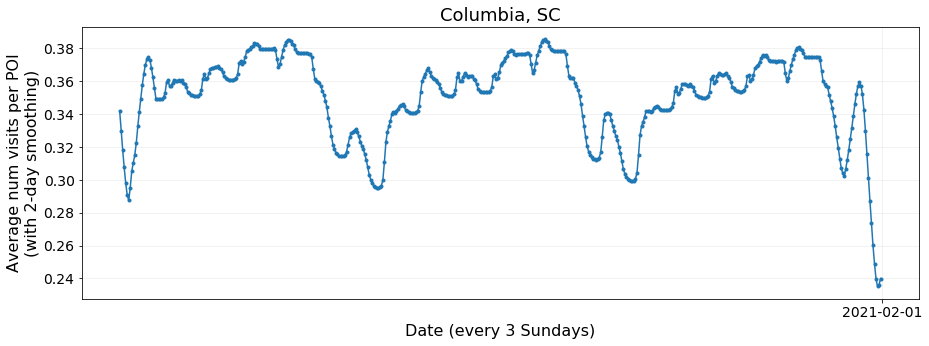

In [32]:
from matplotlib import ticker as tick

fig, ax = plt.subplots(figsize=(15, 5))
x = all_hours
y = apply_smoothing(visits_per_hour, before=24, after=24)
ax.plot_date(x, y, linestyle='-', marker='.')
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlabel('Date (every 3 Sundays)', fontsize=16)
ax.set_ylabel('Average num visits per POI\n(with 2-day smoothing)', fontsize=16)
ax.set_title('%s' % MSAS_TO_PRETTY_NAMES[msa_name], fontsize=18)
ax.tick_params(labelsize=14)
ax.grid(alpha=0.2)
plt.show()

# Post-processing on MSA files: create time-aggregated

In this section, we aggregate data over many weeks to provide time-aggregated estimates for certain POI attributes. 
- During network inference (see generate_ipf.py), we use time-aggregated estimates of each POI's visitors' home CBG distribution.
- In our model (see model_experiments.py), we use time-aggregated estimates for each POI's dwell time.

Since we use time-aggregated estimates, we do not update these values every time we download new SafeGraph data. As of February 2021, we are using the weeks from 2019/12/30 to 2020/10/19 as the basis for time-aggregated information.

In [33]:
pop_df = helper.load_dataframe_to_correct_for_population_size(version='v2', verbose=False)
pop_df.head()

# the output of pop_df has fields of for each week's visitation.
# Each row is a blockgroup

# pop_df = pd.read_csv(PATH_TO_ACS_5YR_DATA)
# pop_df

Processing: 1 / 32 /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/home_panel_summary/2020/12/09/18/home_panel_summary.csv
Processing: 2 / 32 /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/home_panel_summary/2020/12/16/18/home_panel_summary.csv
Processing: 3 / 32 /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/home_panel_summary/2020/12/23/18/home_panel_summary.csv
Processing: 4 / 32 /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/home_panel_summary/2020/12/30/18/home_panel_summary.csv
Processing: 5 / 32 /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/home_panel_summary/2021/01/06/19/home_panel_summary.csv
Processing: 6 / 32 /media/gpu/easystore/Safegraph/Weekly Places Patterns (for data from 2020-11-30 to Present)/home_panel_summary/2021/01/13/19/home_panel_summary.cs

,OBJECTID,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,INTPTLAT,INTPTLON,Shape_Area,GEOID_Data,county_code,cbg_total_population,p_asian,p_black,p_white,CBSA Code,CSA Code,CBSA Title,Metropolitan/Micropolitan Statistical Area,CSA Title,County/County Equivalent,State Name,FIPS State Code,FIPS County Code,GEOID,total_household_income,total_households,mean_household_income,median_household_income,census_block_group,total_cbg_population,number_devices_residing_2020-12-09,number_devices_residing_2020-12-16,number_devices_residing_2020-12-23,number_devices_residing_2020-12-30,number_devices_residing_2021-01-06,number_devices_residing_2021-01-13,number_devices_residing_2021-01-20,number_devices_residing_2021-01-27,number_devices_residing_2021-02-03,number_devices_residing_2021-02-10,number_devices_residing_2021-02-17,number_devices_residing_2021-02-24,number_devices_residing_2021-03-03,number_devices_residing_2021-03-11,number_devices_residing_2021-03-17,number_devices_residing_2021-03-24,number_devices_residing_2021-03-31,number_devices_residing_2021-04-07,number_devices_residing_2021-04-14,number_devices_residing_2021-04-21,number_devices_residing_2021-04-28,number_devices_residing_2021-05-05,number_devices_residing_2021-05-13,number_devices_residing_2021-05-19,number_devices_residing_2021-05-26,number_devices_residing_2021-06-02,number_devices_residing_2021-06-09,number_devices_residing_2021-06-16,number_devices_residing_2021-06-23,number_devices_residing_2021-06-30,number_devices_residing_2021-07-07,number_devices_residing_2021-07-14
0,1.0,1,73,5903,3,33.603461,-86.680672,2.029247e+06,15000US010730059033,1073,1991,0.015068,0.689603,0.286288,13820,142.0,"Birmingham-Hoover, AL",Metropolitan Statistical Area,"Birmingham-Hoover-Talladega, AL",Jefferson County,Alabama,1,73,15000US010730059033,38984602.0,811.0,48069.792848,41875,010730059033,1991,125.0,125.0,119.0,120.0,105.0,116.0,120.0,104.0,111.0,106.0,109.0,110.0,107.0,104.0,104.0,105.0,109.0,105.0,121.0,107.0,108.0,109.0,105.0,106.0,102.0,112.0,111.0,113.0,99.0,105.0,113.0,114.0
1,2.0,1,73,5903,1,33.596329,-86.667229,4.292080e+06,15000US010730059031,1073,2187,0.000000,0.447188,0.476452,13820,142.0,"Birmingham-Hoover, AL",Metropolitan Statistical Area,"Birmingham-Hoover-Talladega, AL",Jefferson County,Alabama,1,73,15000US010730059031,49694694.0,612.0,81200.480392,92649,010730059031,2187,100.0,97.0,92.0,84.0,99.0,100.0,101.0,94.0,99.0,104.0,106.0,86.0,100.0,82.0,87.0,86.0,89.0,86.0,88.0,104.0,95.0,91.0,97.0,98.0,100.0,95.0,97.0,97.0,87.0,94.0,98.0,101.0
2,3.0,1,73,5905,3,33.611071,-86.693884,2.420730e+06,15000US010730059053,1073,2741,0.000000,0.788763,0.176943,13820,142.0,"Birmingham-Hoover, AL",Metropolitan Statistical Area,"Birmingham-Hoover-Talladega, AL",Jefferson County,Alabama,1,73,15000US010730059053,55382145.5,867.0,63877.907151,48906,010730059053,2741,139.0,130.0,137.0,127.0,142.0,148.0,150.0,125.0,140.0,147.0,149.0,130.0,140.0,156.0,162.0,159.0,159.0,156.0,164.0,169.0,152.0,153.0,153.0,147.0,148.0,163.0,157.0,149.0,138.0,137.0,155.0,162.0
3,4.0,1,73,5905,1,33.595858,-86.702036,1.443893e+06,15000US010730059051,1073,1213,0.000000,0.771641,0.228359,13820,142.0,"Birmingham-Hoover, AL",Metropolitan Statistical Area,"Birmingham-Hoover-Talladega, AL",Jefferson County,Alabama,1,73,15000US010730059051,26347269.5,517.0,50961.836557,40679,010730059051,1213,54.0,59.0,57.0,42.0,57.0,49.0,48.0,45.0,47.0,46.0,50.0,46.0,43.0,39.0,43.0,42.0,45.0,49.0,53.0,49.0,51.0,51.0,46.0,46.0,40.0,46.0,48.0,42.0,44.0,53.0,48.0,49.0
4,5.0,1,73,5702,3,33.472276,-86.878081,7.353911e+05,15000US010730057023,1073,412,0.000000,0.961165,0.038835,13820,142.0,"Birmingham-Hoover, AL",Metropolitan Statistical Area,"Birmingham-Hoover-Talladega, AL",Jefferson County,Alabama,1,73,15000US010730057023,8682417.5,205.0,42353.256098,38669,010730057023,412,39.0,40.0,45.0,46.0,47.0,49.0,51.0,42.0,52.0,48.0,42.0,40.0,39.0,42.0,36.0,36.0,34.0,50.0,47.0,50.0,50.0,45.0,46.0,51.0,43.0,45.0,43.0,52.0,48.0,46.0,55.0,59.0


In [102]:
len(pop_df)

202625

In [34]:
# constant info: core, area, aggregated dwell time, aggregated home cbgs
def make_time_aggregated_file_for_msa(msa_name, core_poi_df, pop_df, time_period_strings, dfs=None):
    prefix = '%s_%s' % (time_period_strings[0].split('_')[0], time_period_strings[-1].split('_')[1])
    print('Prefix:', prefix)  # results: 20210125_20210201
    pois_in_msa = set()
    if dfs is None:
        dfs = []
        for ts in time_period_strings:
            df = helper.load_dataframe_for_individual_msa(msa_name, version='v2', time_period=ts) # load the msa pois
            pois_in_msa = pois_in_msa.union(df.index)
            dfs.append(df)
    else:
        copied_dfs = []
        for df in dfs:
            copied_dfs.append(df.copy())  # don't want to modify by accident
            pois_in_msa = pois_in_msa.union(df.index)
        dfs = copied_dfs
    
    pois_in_msa = list(sorted(pois_in_msa))
    base = core_poi_df.loc[pois_in_msa].copy()
    parent_ids = set(core_poi_df.parent_safegraph_place_id)
    is_parent = base.index.isin(parent_ids)
    parents = base[is_parent]
    nonparents = base[~is_parent]
    print('In MSA: %d parent POIs; %d non-parent POIs' % (len(parents), len(nonparents)))
    base = nonparents    
    base['poi_cbg'] = np.nan
    for df in dfs:
        visitor_home_cbg_cols = sorted([col for col in df.columns if col.endswith('visitor_home_cbgs')])
        median_dwell_cols = sorted([col for col in df.columns if col.endswith('median_dwell')])
        cols_to_keep = ['single_poi_cbg'] + visitor_home_cbg_cols + median_dwell_cols
        base = pd.merge(base, df[cols_to_keep], how='left', left_index=True, right_index=True, validate='one_to_one')
        poi_cbg_is_nan = pd.isnull(base['poi_cbg'])  # update poi_cbg data that is still null
        base['poi_cbg'][poi_cbg_is_nan] = base['single_poi_cbg'][poi_cbg_is_nan]  # each df has a single_poi_cbg column
        base = base.drop(columns=['single_poi_cbg'])
        
    visitor_home_cbg_cols = [col for col in base.columns if col.endswith('visitor_home_cbgs')]
    print('Found %d visitor home CBG columns' % len(visitor_home_cbg_cols))
    is_null_mat = pd.isnull(base[visitor_home_cbg_cols])
    base['num_weeks_with_visitor_home_cbgs'] = np.sum(~is_null_mat, axis=1)
    periods_to_include = [c[:10] for c in visitor_home_cbg_cols]  # only keep date string
    base = helper.aggregate_visitor_home_cbgs_over_months(base, population_df=pop_df, 
                                                cutoff_year=None, periods_to_include=periods_to_include)
    base = base.rename(columns={k:'%s_%s' % (prefix, k) for k in ['aggregated_cbg_population_adjusted_visitor_home_cbgs', 
          'aggregated_visitor_home_cbgs']})

    median_dwell_cols = [col for col in base.columns if col.endswith('median_dwell')]
    print('Found %d median dwell columns' % len(median_dwell_cols))
    is_null_mat = pd.isnull(base[median_dwell_cols])
    base['num_weeks_with_median_dwell'] = np.sum(~is_null_mat, axis=1)
    base['%s_median_of_median_dwell' % prefix] = np.nanmedian(base[median_dwell_cols].values, axis=1)
    
    cols_to_drop = [col for col in base.columns if '.' in col]  # time-varying are <date>.<col_name>
    base = base.drop(columns=cols_to_drop)
    for k in ['%s_aggregated_cbg_population_adjusted_visitor_home_cbgs' % prefix, 
              '%s_aggregated_visitor_home_cbgs' % prefix]:
        base[k] = base[k].map(lambda x:json.dumps(dict(x))) # cast to json so properly saved in CSV. 
    path_to_csv = os.path.join(NEW_STRATIFIED_BY_AREA_DIR, 'time_aggregated/%s_%s.csv' % (prefix, msa_name))
    print('Saving at', path_to_csv)
    base.to_csv(path_to_csv)
    return base

In [35]:
stratified_by_msa_dir = os.path.join(NEW_STRATIFIED_BY_AREA_DIR, '20210125_20210201')
if not os.path.exists(stratified_by_msa_dir):
    os.makedirs(stratified_by_msa_dir)

fns = os.listdir(stratified_by_msa_dir)  # file list
va_msas = []

# get the target state
for fn in fns:
    msa = fn.split('.')[0]  # drop .csv
    states = msa.split('_')[1:]
    # va_msas.append(msa)
    if 'SC' in states:
        va_msas.append(msa)
print('Found %d MSAs that overlap with SC' % len(va_msas))
print(va_msas)

Found 10 MSAs that overlap with SC
['Augusta_Richmond_County_GA_SC', 'Greenville_Anderson_SC', 'Charleston_North_Charleston_SC', 'Charlotte_Concord_Gastonia_NC_SC', 'Columbia_SC', 'Florence_SC', 'Hilton_Head_Island_Bluffton_SC', 'Myrtle_Beach_Conway_North_Myrtle_Beach_SC_NC', 'Spartanburg_SC', 'Sumter_SC']


In [36]:
# time_period_strings = ['20191230_20200224', '20200302_20200608', '20200615_20200817', '20200824_20201019']
time_period_strings = ['20210120_20210203']  # not only a week
for msa_name in va_msas:
    make_time_aggregated_file_for_msa(msa_name, core_poi_df, pop_df, time_period_strings, dfs=None)

Prefix: 20210120_20210203
filename: /media/gpu/easystore/all_aggregate_data/stratified_by_metro_area/20210120_20210203/Augusta_Richmond_County_GA_SC.csv
Loaded 7609 rows for Augusta_Richmond_County_GA_SC in 3.569 seconds
In MSA: 399 parent POIs; 7210 non-parent POIs
Found 3 visitor home CBG columns
Aggregating data from: ['2021-01-20.visitor_home_cbgs', '2021-01-27.visitor_home_cbgs', '2021-02-03.visitor_home_cbgs']
Filling 2021-01-20.visitor_home_cbgs with Counter objects


/media/gpu/easystore/covid-mobility-tool/env_dir/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Finished adjusting home CBG counts for 2021-01-20 [time=0.063s] had to fill in or clip coverage for 71.914008% of rows; in those cases used median coverage 0.041
Filling 2021-01-27.visitor_home_cbgs with Counter objects
Finished adjusting home CBG counts for 2021-01-27 [time=0.074s] had to fill in or clip coverage for 71.248266% of rows; in those cases used median coverage 0.038
Filling 2021-02-03.visitor_home_cbgs with Counter objects
Finished adjusting home CBG counts for 2021-02-03 [time=0.071s] had to fill in or clip coverage for 71.955617% of rows; in those cases used median coverage 0.039
y: 0
y: 0
Aggregating CBG visitors over 3 time periods took 0.956 seconds
Fraction 0.874 of POIs have CBG visitor data
Found 3 median dwell columns
Saving at /media/gpu/easystore/all_aggregate_data/stratified_by_metro_area/time_aggregated/20210120_20210203_Augusta_Richmond_County_GA_SC.csv
Prefix: 20210120_20210203
filename: /media/gpu/easystore/all_aggregate_data/stratified_by_metro_area/202101

Final columns:

safegraph_place_id

parent_safegraph_place_id

location_name

safegraph_brand_ids

brands

top_category

sub_category

naics_code

latitude

longitude

street_address

city

region

postal_code

open_hours

polygon_class

area_square_feet

poi_cbg

num_weeks_with_visitor_home_cbgs

20210106_20210120_aggregated_visitor_home_cbgs

20210106_20210120_aggregated_cbg_population_adjusted_visitor_home_cbgs

num_weeks_with_median_dwell

20210106_20210120_median_of_median_dwell

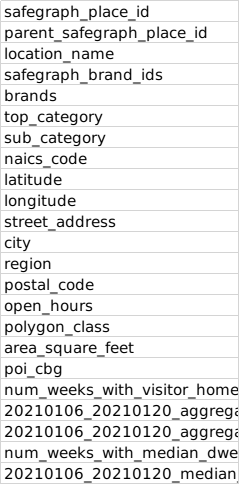


In [ ]:
import pyan
from IPython.display import HTML
HTML(pyan.create_callgraph(filenames="**/*.py", format="html"))


In [20]:
import numpy as np
import pandas as pd

npz_file = r'/media/gpu/easystore/all_aggregate_data/ipf_output/Columbia_SC/2020-12-28-10.npz'


np.load(npz_file)['data'].sum()

65648.91847540307

In [8]:
np.load(npz_file).files

['indices', 'indptr', 'format', 'shape', 'data']

In [16]:
np.load(npz_file)['data'].sum()

56264.93643118425

In [ ]:
import numpy as np
import pandas as pd

npz_file = r'/media/gpu/easystore/all_aggregate_data/ipf_output/Columbia_SC/2021-01-31-14.npz'


np.array(np.load(npz_file)['data']).shape